In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from scipy.io import wavfile
import statsmodels.api as sm
from scipy.signal import find_peaks


In [2]:
def create_windows(data, hann_window, window_size, hop_size):
    # create windows over the audio signal
    data_windows = sliding_window_view(data, window_size)[::hop_size,:]
    # repeat hann windows for each window in the audio signal and multiply
    hann_windows = np.repeat(hann_window.reshape(1, -1), data_windows.shape[0], axis=0)
    # Multiply hann window with audio signal
    data_windows = np.multiply(data_windows, hann_windows)
    data_windows.shape
    return data_windows

9607 16000
aa 709.5821398284794
11146 16000
ii 338.85321267786554
11889 16000
uu 278.9194396431208
9845 16000
e 619.8294975025427
9845 16000
o 354.5937309791999


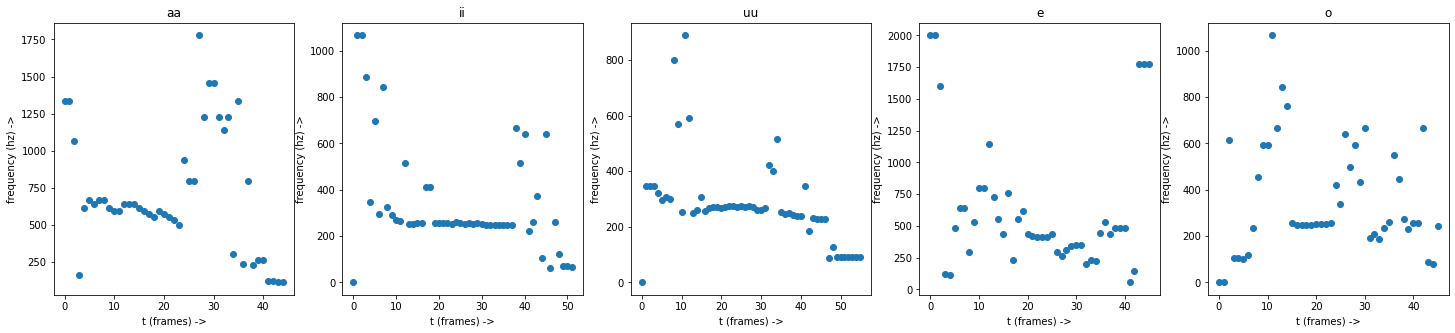

In [6]:
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
for i, vowel in enumerate(['aa', 'ii', 'uu', 'e', 'o']):
    filepath = f'../recordings_16000/vowels/{vowel}_16000.wav'  # this is me speaking with pauses
    sr, data = wavfile.read(filepath)
    data = np.array(data / 32767.0, dtype=np.float32)
    print(len(data), sr)

    window_size = int(0.025 * sr)  # 25 ms windows
    # hop_size = window_size//2
    hop_size = 1
    hann_window = np.hanning(window_size)
    data_windows = create_windows(data, hann_window, window_size, hop_size)
    n_windows = data_windows.shape[0]

    # Calculate short-term energy
    energy_windows = np.power(data_windows, 2).sum(axis=1) / window_size

    # Calculate ZCR
    zcr_windows = []
    data_raw_windows = create_windows(data, np.ones(window_size), window_size, hop_size)
    for idx in range(n_windows):
        dw = data_raw_windows[idx]
        dw = dw - np.mean(dw)
        zcr_indices, = np.nonzero(np.diff(dw > 0))
    #     print(len(zcr_indices))
        zcr_windows.append(len(zcr_indices) / window_size)

    # Set Thresholds
    # Estimate STE thresholds from first ~10 ms (white noise recorded)
    K = int(sr * 0.01)
    STE_THRESHOLD = np.max(energy_windows[:K])

    # Estimated ZCR from first ~10 ms of noisy audio sample
    ZCR_THRESHOLD = np.mean(zcr_windows[:K])

    voiced = []
    for zcr, ste in zip(zcr_windows, energy_windows):
        if ste < STE_THRESHOLD and zcr > ZCR_THRESHOLD:
            voiced.append(0)
        else:
            voiced.append(1)

    y = np.multiply(voiced, data[:len(voiced)])

    window_size = int(sr * 0.025)
    hop_size = window_size // 2
    hann_window = np.hanning(window_size)

    y_windows = create_windows(y, hann_window, window_size, hop_size)

    pitches = []
    prev_lag, prev_pitch = 0, 0
    for idx in range(y_windows.shape[0]):
        s = y_windows[idx]
        
        mu, sigma = np.mean(s), np.var(data)
        ndata = s - mu
        auto_corr = np.correlate(s - mu, s - mu, 'full')[len(s)-1:] 
        auto_corr = auto_corr / (sigma * len(s))
        
        #Find peaks and pick first one
        peaks = find_peaks(auto_corr)[0] 
        try:
#             lag = peaks[0] 
            lag = peaks[1] - peaks[0]
            prev_lag = lag
        except:
            lag = prev_lag
        pitch = sr / lag 
        if pitch > 2000:
            pitch = prev_pitch
        prev_pitch = pitch
        pitches.append(pitch)

    print(vowel, sum(pitches)/len(pitches))
    axes[i].scatter(list(range(len(pitches))), pitches)
    axes[i].set_ylabel('frequency (hz) ->')
    axes[i].set_xlabel('t (frames) ->')
    axes[i].set_title(vowel)
plt.show()